The Calamity roadmap will involve. 

* inverting the wedge
* performing abscal with no sky-model
* calibrating out redundancies.

In this notebook, we generate some simulations to test our methods on.

In [1]:
%matplotlib inline
import numpy as np
import healvis as hv
import healpy as hp
import matplotlib.pyplot as plt
from healvis.data import DATA_PATH
import os
from pyuvdata import UVData

In [2]:
uvdc = UVData()
#create layout
spacings = [0, 1, 6, 10, 23, 26, 34, 41, 53, 55]
ddish = 15.0
antpos = [np.array([ddish * m, 0.0, 0.0]) for m in spacings]
uvh5_data = f'simulated_array_ddish_{int(ddish)}_nant_{len(antpos)}'
uvdc.read_uvh5(uvh5_data)


antenna_diameters is not set. Using known values for HERA.


In [3]:
uvdc.data_array.shape

(45, 1, 400, 1)

In [4]:
dgrid = uvdc.data_array.squeeze()

In [5]:
from uvtools import dspec
def fft_freq(data, window='bh7'):
    w = dspec.gen_window(window, data.shape[1])
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(data * w[None,:], axes=1),axis=1),axes=1)

In [6]:
from matplotlib.colors import LogNorm

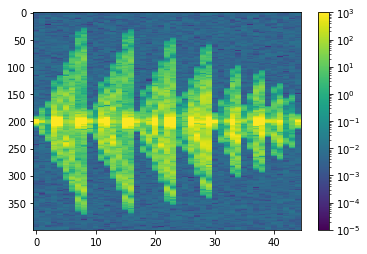

In [7]:
plt.imshow(np.abs(fft_freq(dgrid)).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

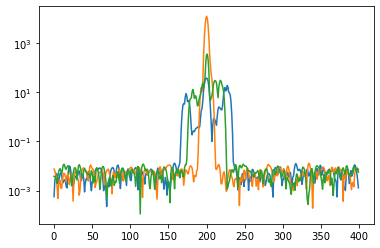

In [8]:
plt.plot(np.abs(fft_freq(dgrid))[10])
plt.plot(np.abs(fft_freq(dgrid))[0])
plt.plot(np.abs(fft_freq(dgrid))[1])


plt.yscale('log')

Try fitting to sinusoids

In [9]:
uvals = np.outer(np.linalg.norm(uvdc.uvw_array,axis=1), uvdc.freq_array[0]/3e8)
umax=uvals.max()

In [10]:
eta_max = 15. / 3e8

In [11]:
eta_max

5e-08

In [12]:
dof_freq = int(np.ceil(2 * eta_max * (uvdc.freq_array.max()-uvdc.freq_array.min())))
print(dof_freq)
dof_uv = int(np.ceil(2 * umax))
print('Number of degrees of freedom in our model:'+ str(dof_freq * dof_uv))
print('Number of measurements: '+ str(len(dgrid.flatten())))

6
Number of degrees of freedom in our model:5940
Number of measurements: 18000


In [13]:
bandwidth = np.abs(uvdc.freq_array.max() - uvdc.freq_array.min())
ells = np.linspace(-1, 1, 2 * int(np.ceil(umax)), endpoint=False)
etas = np.linspace(-eta_max, eta_max, 2 * int(np.ceil(eta_max * bandwidth )))
umodes = [np.exp(-2j * np.pi * uvals * ell / (2. * umax)) for ell in ells]
etamodes = [np.exp(-2j * np.pi * uvdc.freq_array[0] * eta / (2 * bandwidth)) for eta in etas]
modes = []
for etamode in etamodes:
    for umode in umodes:
        modes.append((umode * etamode).flatten())
modes = np.asarray(modes)

In [14]:
x0 = np.array([np.dot(mode,  dgrid.flatten()) for mode in modes])

In [15]:
import scipy.optimize as op

In [16]:
modes.shape

(5940, 18000)

In [21]:
res = op.lsq_linear(modes.T, dgrid.flatten())

In [31]:
mdl = modes.T @ res['x'] 

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


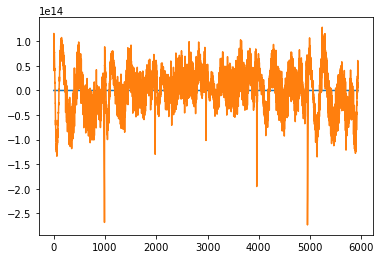

In [35]:
plt.plot(x0)
plt.plot(res['x'])

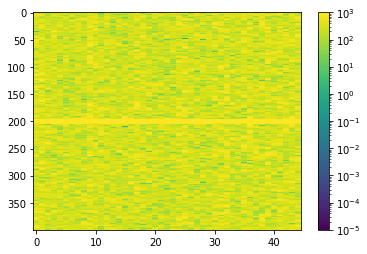

In [32]:
plt.imshow(np.abs(fft_freq(mdl.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

Looks like that failed miserably. Lets go with the array inversion, kriging approach.

In [17]:
fvals = np.asarray([uvdc.freq_array[0] for u in range(uvals.shape[0])])

In [18]:
ugx, ugy = np.meshgrid(uvals, uvals)
fx, fy = np.meshgrid(fvals, fvals)
cov_fg = 1e9 * np.sinc(2 * (ugx - ugy) ) * np.sinc(2 * eta_max * (fx - fy))

In [19]:
cov_tot = np.identity(len(uvals.flatten())) + cov_fg
fg_fit_operator = cov_fg @ np.linalg.inv(cov_tot)

In [20]:
mdl = (fg_fit_operator @ dgrid.flatten()).reshape(dgrid.shape)

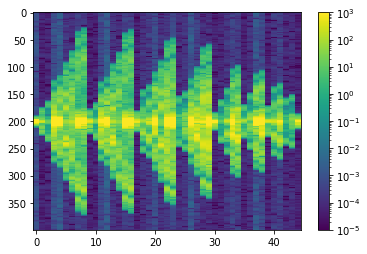

In [21]:
plt.imshow(np.abs(fft_freq(mdl.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

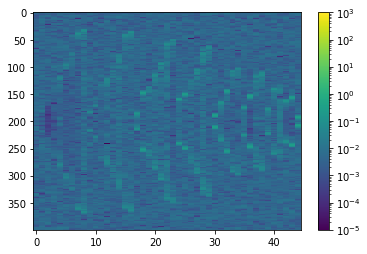

In [22]:
plt.imshow(np.abs(fft_freq(dgrid-mdl.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

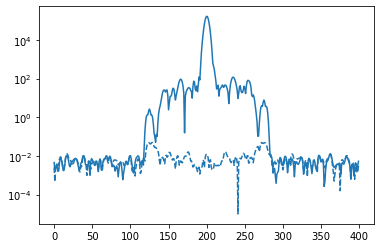

In [41]:
l0=plt.plot(np.abs(fft_freq(dgrid))[12])[0]
plt.plot(np.abs(fft_freq(dgrid-mdl)[12]), color=l0.get_color(), ls='--')
#l0=plt.plot(np.abs(fft_freq(dgrid))[0])[0]
#plt.plot(np.abs(fft_freq(dgrid-mdl)[0]), color=l0.get_color(), ls='--')
#l0=plt.plot(np.abs(fft_freq(dgrid))[1])[0]
#plt.plot(np.abs(fft_freq(dgrid-mdl)[1]), color=l0.get_color(), ls='--')

plt.yscale('log')

Lets try using the principal components of the fg covariance to do the fit.

In [24]:
evals, evecs = np.linalg.eigh(cov_tot)

We see that the number of degrees of freedom is more like around 7500 for this basis. Perhaps this is because the 

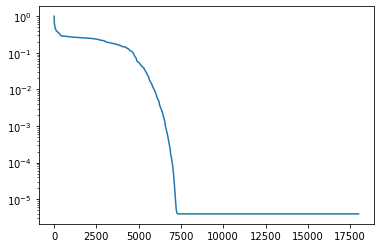

In [25]:
plt.plot(np.sqrt(evals[::-1]/evals.max()))
plt.yscale('log')

In [30]:
to_fit = np.sqrt(evals / evals.max()) >= 1e-5

In [31]:
evecs.shape

(18000, 18000)

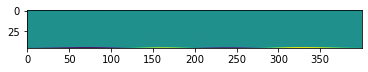

In [44]:
plt.imshow(evecs[:,-10].reshape(dgrid.shape))

In [32]:
evecs[to_fit].shape

(7171, 18000)

In [46]:
res_dy = op.lsq_linear(evecs[:, to_fit], dgrid.flatten())

Because vectors are already orthonormal, we can just take dot products without doing the whole rigamaroll of lsq linear fitting.

In [51]:
mdl_dy = res_dy['x'] @ evecs[:,to_fit].T


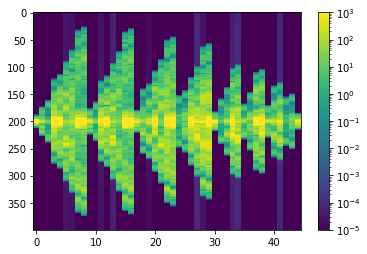

In [52]:
plt.imshow(np.abs(fft_freq(mdl_dy.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

An abscal recipe

* compute  $\left\{\hat{f}_k^0 \right\}$ by taking dot products of eigenvectors with data.
* solve for a first guess at $\hat{G}(\nu)$ by solving \begin{equation} \log(G(\nu)) = \log(V) - \log(M) \end{equation} where $V$ are the measured visibilities and $M$ is the model from our dot product.
* Apply $G$ and solve for next guess of $M$. 
* Repeate with loop $\log(G^m) = \log(V) - \log(M^{m})$ and $M^{m} = \Lambda^T \Lambda V (V / G^{m-1})$